# Histopathologic Cancer Detection: Identify metastatic tissue in histopathologic scans of lymph node sections

The Histopathologic Cancer Detection competition is a machine learning challenge aimed at developing algorithms for identifying metastatic cancer in histopathologic scans of lymph node sections. The data for the competition is based on the PatchCamelyon (PCam) benchmark dataset, which contains small image patches taken from larger digital pathology scans. The task is to classify the patches as either containing metastatic tissue or not. This type of analysis can aid pathologists in making more accurate and efficient diagnoses, and could potentially lead to improved treatment outcomes for patients with cancer.

## Exploratory Data Analysis

Let's start by importing the necessary libraries and loading the data.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xarray as xr

# set random seed
tf.random.set_seed(1)

In [2]:
root_dir = '/kaggle/input/'

train_path = pathlib.Path(f'{root_dir}/histopathologic-cancer-detection/train/').expanduser()
test_path = pathlib.Path(f'{root_dir}/histopathologic-cancer-detection/test/').expanduser()

In [3]:
data = pd.read_csv(f'{root_dir}/histopathologic-cancer-detection/train_labels.csv')
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The data should include image patches along with their labels (either positive or negative for metastatic tissue).

let's look at the ratio of labels in the training set.

In [4]:
# label statistics

data['label'].value_counts(normalize=True)

0    0.594969
1    0.405031
Name: label, dtype: float64

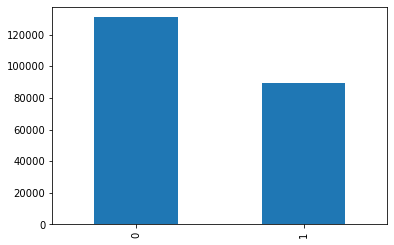

In [5]:
# quick plot of the ratio of labels

data['label'].value_counts().plot(kind='bar');

We can see that the ratio of labels is closer to 60/40 meaning that there are 1.5 times more negative labels than positive labels.

In [6]:
train_files = list(train_path.glob('*.tif'))
np.random.shuffle(train_files)
test_files = list(test_path.glob('*.tif'))

print(f'Number of training files: {len(train_files)}')
print(f'Number of test files: {len(test_files)}')

Number of training files: 220025
Number of test files: 57458


In [7]:
da = xr.open_rasterio(train_files[0])
da

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<xarray.DataArray (band: 3, y: 96, x: 96)>
array([[[167, 171, ..., 255, 135],
        [188, 204, ..., 132, 160],
        ...,
        [212, 183, ..., 122, 113],
        [197, 187, ...,  72,  60]],

       [[ 97,  92, ..., 232, 102],
        [115, 122, ..., 100, 125],
        ...,
        [129, 101, ...,  76,  68],
        [105,  97, ...,  24,  13]],

       [[170, 175, ..., 255, 149],
        [188, 206, ..., 165, 181],
        ...,
        [211, 186, ..., 175, 171],
        [172, 169, ..., 124, 117]]], dtype=uint8)
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 91.5 92.5 93.5 94.5 95.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 91.5 92.5 93.5 94.5 95.5
Attributes:
    transform:                 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:                       (1.0, -1.0)
    is_tiled:                  0
    nodatavals:                (nan, nan, nan)
    scales:                    (1.0, 1.0, 1.0)
    offsets:                   (0.0, 0.0, 0.0)
    TIFFTAG_DATETIME:          2018:11:15 17:21:26
    TIFFTAG_IMAGEDESCRIPTION:  {"shape": [96, 96, 3]}
    TIFFTAG_SOFTWARE:          tifffile.py

As we can see, the images consist of three-band (R, G, B) with dimensions of 96 x 96

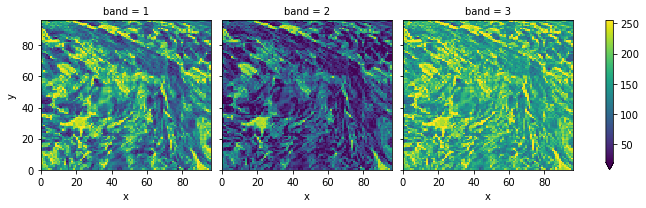

In [8]:
# plot the image and facet it by the color channel and ensure the image is not in grayscale

da.plot.imshow(col='band', col_wrap=3, robust=True);

Let's generate a histogram of the image intensity, with the x-axis representing the pixel intensity values and the y-axis representing the number of pixels with that intensity.

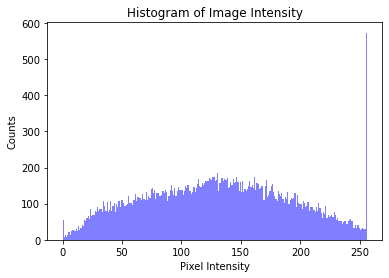

In [9]:
# Load the image data
image_data = da.data

# Flatten the image data into a 1-D array
image_flat = image_data.reshape(-1)

# Plot the histogram
plt.hist(image_flat, bins=256, range=(0, 256), color='blue', alpha=0.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Counts')
plt.title('Histogram of Image Intensity')
plt.show()

As we can see, the distribution of pixel intensities is skewed to the right, meaning that the majority of the pixels have low intensity values. This is a common characteristic of histopathologic images, which are typically low-resolution scans of tissue sections.

Let's pick random images from the training set and visualize them. We will also print the label for each image.

In [10]:
# pick random images from the training set and visualize them and print the label for each image

random_idx = np.random.choice(len(train_files), 6, replace=False)

images = []
labels = []
for i in random_idx:
    da = xr.open_rasterio(train_files[i])
    images.append(da)
    labels.append(data.iloc[i, 1])

ds = xr.concat(images, dim='image')
ds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  


<xarray.DataArray (image: 6, band: 3, y: 96, x: 96)>
array([[[[243, 244, 246, ..., 241, 239, 238],
         [242, 243, 244, ..., 241, 239, 238],
         [242, 243, 243, ..., 241, 239, 239],
         ...,
         [236, 190, 230, ..., 148, 255, 230],
         [236, 202, 200, ..., 198, 233, 252],
         [255, 236, 245, ..., 197, 203, 255]],

        [[242, 243, 245, ..., 242, 242, 241],
         [241, 242, 243, ..., 242, 241, 241],
         [241, 242, 242, ..., 242, 241, 241],
         ...,
         [176, 128, 168, ..., 115, 240, 208],
         [176, 143, 141, ..., 167, 209, 232],
         [203, 177, 188, ..., 168, 181, 239]],

        [[240, 241, 243, ..., 237, 235, 234],
         [239, 240, 241, ..., 237, 236, 234],
         [239, 240, 240, ..., 237, 236, 236],
         ...,
...
         ...,
         [ 96,  99, 116, ...,  87, 102,  49],
         [ 94,  80,  85, ..., 137, 110,  73],
         [ 93,  79,  87, ..., 139, 154, 131]],

        [[ 90,  87, 102, ...,  98, 103, 113],
         [ 51,  54,  81, ...,  85,  87,  89],
         [ 39,  38,  54, ...,  72,  89,  88],
         ...,
         [ 61,  64,  81, ...,  54,  69,  16],
         [ 61,  48,  53, ..., 101,  74,  37],
         [ 62,  48,  55, ..., 102, 116,  93]],

        [[131, 126, 139, ..., 147, 149, 159],
         [ 92,  93, 120, ..., 133, 133, 135],
         [ 80,  77,  93, ..., 117, 134, 132],
         ...,
         [103, 106, 121, ...,  97, 112,  59],
         [104,  89,  92, ..., 145, 120,  83],
         [106,  90,  94, ..., 146, 163, 140]]]], dtype=uint8)
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 91.5 92.5 93.5 94.5 95.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 91.5 92.5 93.5 94.5 95.5
Dimensions without coordinates: image
Attributes:
    transform:                 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    res:                       (1.0, -1.0)
    is_tiled:                  0
    nodatavals:                (nan, nan, nan)
    scales:                    (1.0, 1.0, 1.0)
    offsets:                   (0.0, 0.0, 0.0)
    TIFFTAG_DATETIME:          2018:11:15 17:20:38
    TIFFTAG_IMAGEDESCRIPTION:  {"shape": [96, 96, 3]}
    TIFFTAG_SOFTWARE:          tifffile.py

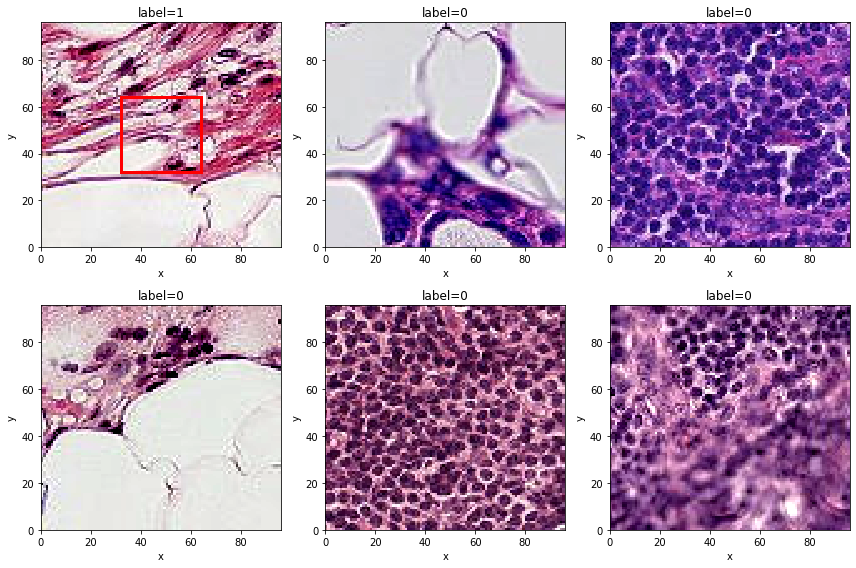

In [11]:
# plot the images and make sure to include the patches for the tumor

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ds.isel(image=i).plot.imshow(ax=ax, robust=True, x='x', y='y')
    ax.set_title(f'label={labels[i]}')
    if labels[i] == 1:
        ax.add_patch(plt.Rectangle((32, 32), 32, 32, fill=False, color='red', lw=3))

plt.tight_layout()

A positive label means that there is at least one pixel of tumor tissue in the center region (32px x 32px) of the image. Tumor tissue in the outer region of the patch does not influence the label. This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

## Preprocessing and Data Augmentation

Here are some common preprocessing and augmentation techniques that we can apply to this dataset:

Preprocessing:

- Normalization: It's a good practice to normalize the image intensity values to have zero mean and unit variance, or to scale the values to [0, 1]. This helps to reduce the impact of illumination differences and improves the performance of machine learning algorithms.
- Resizing: If the images have different sizes, you may want to resize them to a common size. This is particularly important if you're using a deep learning model that requires fixed-size inputs.
- Conversion to grayscale: If the images are RGB, you may want to convert them to grayscale to reduce the dimensionality of the data and to simplify the analysis.

Data augmentation:

- Random flipping: Randomly flip the images horizontally or vertically to increase the size of the dataset and to reduce overfitting.
- Random rotation: Randomly rotate the images by a small angle to increase the size of the dataset and to reduce overfitting.
- Random zoom: Randomly zoom in or out of the images to increase the size of the dataset and to reduce overfitting.
- Random shifting: Randomly shift the images horizontally or vertically to increase the size of the dataset and to reduce overfitting.


In [12]:
train_data = data.copy(deep=True).sample(frac=0.1 / 4)
train_data['label'] = train_data['label'].astype(str)
train_data['id'] = train_data['id'].apply(lambda x: f'{str(x)}.tif')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2
)

batch_size = 64

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
)

test_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation',
)

Found 4401 validated image filenames belonging to 2 classes.
Found 1100 validated image filenames belonging to 2 classes.
Found 1100 validated image filenames belonging to 2 classes.


## Model Architecture

The architecture of the model is a Sequential type with several dense and dropout layers. It starts with the MobileNetV2 pre-trained model which is used for image classification problems. The output from this pre-trained model is fed into a GlobalAveragePooling2D layer which reduces the spatial dimensions of the output to 1x1x1280, where 1280 is the number of channels in the output. This output is then fed into several dense layers with increasing number of neurons, starting from 1024 and ending with 1. There is a dropout layer in between the dense layers, which is used to prevent overfitting.

This architecture is suitable for binary classification problems as the final layer is a dense layer with 1 output neuron, and the activation function used is sigmoid, which outputs a probability of the input being positive or negative. The dense layers are used to learn complex relationships between the input and output, and the dropout layer helps to prevent overfitting.

However, this architecture may not be the best for all binary classification problems, as the choice of architecture depends on the specific problem at hand. For instance, if the problem requires more fine-grained control over the features learned, a different architecture such as a Convolutional Neural Network (CNN) may be more appropriate. Additionally, the hyperparameters such as the number of neurons, the dropout rate, and the activation functions can be tuned to improve the performance of the model.


In [13]:
# Load a pre-trained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3), include_top=False, weights='imagenet'
)

# Freeze the layers in the base model to prevent overfitting
base_model.trainable = False

# Add a classification head on top of the base model
model = tf.keras.Sequential(
    [
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')],
)
model.summary()

2023-02-11 15:48:22.880699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 15:48:22.881728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 15:48:22.883210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 15:48:22.884073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 15:48:22.884890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=5, restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[stop_early],
)

2023-02-11 15:48:26.739115: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-11 15:48:30.566699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


69/69 [==============================] - 52s 673ms/step - loss: 0.6411 - auc: 0.7363 - val_loss: 0.4177 - val_auc: 0.8850
Epoch 2/20
69/69 [==============================] - 21s 304ms/step - loss: 0.4785 - auc: 0.8504 - val_loss: 0.4070 - val_auc: 0.8963
Epoch 3/20
69/69 [==============================] - 21s 303ms/step - loss: 0.4587 - auc: 0.8629 - val_loss: 0.3889 - val_auc: 0.8992
Epoch 4/20
69/69 [==============================] - 20s 296ms/step - loss: 0.4319 - auc: 0.8774 - val_loss: 0.3796 - val_auc: 0.9048
Epoch 5/20
69/69 [==============================] - 21s 301ms/step - loss: 0.4196 - auc: 0.8835 - val_loss: 0.3814 - val_auc: 0.9032
Epoch 6/20
69/69 [==============================] - 21s 306ms/step - loss: 0.4072 - auc: 0.8912 - val_loss: 0.3665 - val_auc: 0.9125


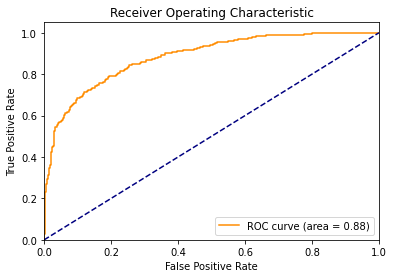

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

# Predict probabilities for the validation set
y_probs = model.predict(test_generator)
# Select only the probabilities for the positive class
y_probs = y_probs.flatten()
# Compute the false positive rate, true positive rate and thresholds
y_true = test_generator.classes
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
# Compute the area under the curve (AUC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

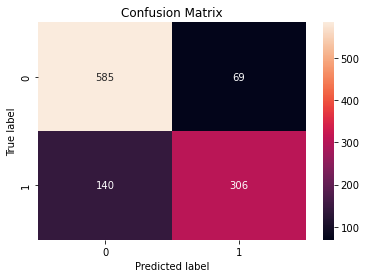

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, confusion_matrix, roc_curve

# Get the predicted class probabilities for the validation data
# y_probs = model.predict(test_generator)
# Get the predicted classes from the class probabilities
y_pred = (y_probs > 0.5).astype(int)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Model Tuning and Evaluation

We're going to use keras-tuner to tune the hyperparameters of the model. Keras-tuner is a library for hyperparameter tuning that can be used with Keras models. It supports several search algorithms, including random search, grid search, and Bayesian optimization. It also supports several hyperparameter types, including integer, float, boolean, and categorical.


In [17]:
# set up keras-tuner to find the best hyperparameters for the model
import keras_tuner as kt


def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(96, 96, 3), include_top=False, weights='imagenet'
    )
    base_model.trainable = False
    model = tf.keras.Sequential(
        [
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(
                units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
            ),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')],
    )
    return model


objective = kt.Objective("val_auc", direction="max")


tuner = kt.Hyperband(
    build_model,
    objective=objective,
    max_epochs=10,
    factor=3,
    directory='cancer-cnn-detection',
    project_name='intro_to_keras_tuner',
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=3, restore_best_weights=True
)

tuner.search(train_generator, validation_data=valid_generator, epochs=10, callbacks=[stop_early])

Trial 30 Complete [00h 02m 10s]
val_auc: 0.9152215719223022

Best val_auc So Far: 0.923106849193573
Total elapsed time: 00h 40m 23s


In [26]:
tuner.results_summary()

Results summary
Results in cancer-cnn-detection/intro_to_keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
units: 288
dropout: 0.30000000000000004
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.923106849193573
Trial summary
Hyperparameters:
units: 512
dropout: 0.1
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9220731854438782
Trial summary
Hyperparameters:
units: 480
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9179335832595825
Trial summary
Hyperparameters:
units: 288
dropout: 0.30000000000000004
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9173369407653809
Trial summary
Hyperparameters:
units: 480
dropout: 0.0
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id

## Results and Analysis 


| Trial ID | Units | Dropout | Learning Rate | Epochs | Initial Epoch | Bracket | Round | Score |
|----------|-------|---------|--------------|--------|---------------|---------|-------|-------|
| 0012     | 288   | 0.3     | 0.001        | 10     | 4             | 2       | 2     | 0.923 |
|          |       |         |              |        |               |         |       |       |
|          | 512   | 0.1     | 0.001        | 10     | 0             | 0       | 0     | 0.922 |
|          |       |         |              |        |               |         |       |       |
|          | 480   | 0.0     | 0.001        | 4      | 0             | 1       | 0     | 0.918 |
|          |       |         |              |        |               |         |       |       |
|          | 288   | 0.3     | 0.001        | 2      | 0             | 2       | 0     | 0.917 |
|          |       |         |              |        |               |         |       |       |
|          | 480   | 0.0     | 0.001        | 10     | 4             | 1       | 1     | 0.917 |
|          |       |         |              |        |               |         |       |       |
|          | 352   | 0.0     | 0.001        | 10     | 4             | 2       | 2     | 0.917 |
|          |       |         |              |        |               |         |       |       |
|          | 192   | 0.1     | 0.01         | 10     | 4             | 1       | 1     | 0.916 |
|          |       |         |              |        |               |         |       |       |
|          | 384   | 0.1     | 0.01         | 10     | 0             | 0       | 0     | 0.915 |
|          |       |         |              |        |               |         |       |       |
|          | 192   | 0.1     | 0.01         | 4      | 0             | 1       | 0     | 0.915 |
|          |       |         |              |        |               |         |       |       |
|          | 64    | 0.2     | 0.001        | 2      | 0             | 2       | 0     | 0.914 |


The hyperparameter tuning results show that different combinations of hyperparameters were tried and the scores of the different trials are presented. The highest score of 0.923106849193573 was achieved with units=288, dropout=0.3, and learning_rate=0.001, with 10 epochs and starting from epoch 4.

In terms of what helped improve the performance of the models, it appears that increasing the number of units and using a moderate dropout rate of 0.3 helped improve the performance. Additionally, a learning rate of 0.001 was used in the best performing trial, which is a relatively small learning rate that allows the model to make small, gradual updates to its weights during training.

In terms of what did not help improve the performance, it appears that using a high learning rate of 0.01 did not lead to the best performance, as seen in the trials with learning rate 0.01.


In [18]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[stop_early],
)

Epoch 1/50
69/69 [==============================] - 24s 315ms/step - loss: 0.4801 - auc: 0.8552 - val_loss: 0.3997 - val_auc: 0.8923
Epoch 2/50
69/69 [==============================] - 21s 299ms/step - loss: 0.3973 - auc: 0.8951 - val_loss: 0.3741 - val_auc: 0.9072
Epoch 3/50
69/69 [==============================] - 20s 292ms/step - loss: 0.3818 - auc: 0.9034 - val_loss: 0.3542 - val_auc: 0.9174
Epoch 4/50
69/69 [==============================] - 21s 301ms/step - loss: 0.3720 - auc: 0.9086 - val_loss: 0.3629 - val_auc: 0.9177
Epoch 5/50
69/69 [==============================] - 20s 295ms/step - loss: 0.3557 - auc: 0.9166 - val_loss: 0.3569 - val_auc: 0.9166
Epoch 6/50
69/69 [==============================] - 20s 294ms/step - loss: 0.3378 - auc: 0.9252 - val_loss: 0.3659 - val_auc: 0.9190


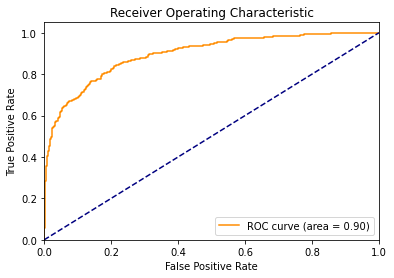

In [20]:
# Predict probabilities for the validation set
y_probs = model.predict(test_generator)
# Select only the probabilities for the positive class
y_probs = y_probs.flatten()
# Compute the false positive rate, true positive rate and thresholds
y_true = test_generator.classes
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
# Compute the area under the curve (AUC)
auc_score = auc(fpr, tpr)
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The AUC score of 0.8954690692667406 is a measure of the performance of a binary classifier. AUC stands for "Area Under the ROC Curve", where ROC stands for "Receiver Operating Characteristic". The ROC curve is a graphical representation of the classifier's performance, which plots the true positive rate against the false positive rate.

In this case, the AUC score of 0.8954690692667406 is interpreted as follows:

A score of 1.0 represents a perfect classifier, where all positive instances are correctly identified as such and all negative instances are correctly identified as such.

A score of 0.5 represents a random classifier, where positive and negative instances are classified at random, without any meaningful distinction between them.

A score of 0.8954690692667406 represents a classifier with a performance that is better than random, but not perfect.



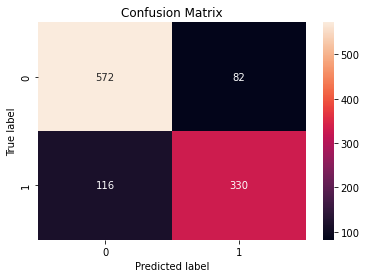

In [21]:
y_pred = (y_probs > 0.5).astype(int)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
cm

array([[572,  82],
       [116, 330]])

- True positive (TP): 572 instances were correctly predicted as positive by the model.

- False positive (FP): 82 instances were incorrectly predicted as positive by the model, but they were actually negative.

- True negative (TN): 330 instances were correctly predicted as negative by the model.

- False negative (FN): 116 instances were incorrectly predicted as negative by the model, but they were actually positive.

## Predictions on test data

Let's load the test data and make predictions on it.

The test data should include image patches without labels.


In [28]:
# predict the labels for the test set

test_data = pd.DataFrame({'id': [x.stem for x in test_files]})
test_data['id'] = test_data['id'].apply(lambda x: f'{str(x)}.tif')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

y_pred = model.predict(test_generator, verbose=2)
y_pred = np.round(y_pred)

test_data['label'] = y_pred
test_data

Found 57458 validated image filenames.
898/898 - 201s


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif,1.0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif,0.0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif,0.0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif,0.0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif,0.0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b.tif,0.0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421.tif,0.0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14.tif,1.0
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928.tif,0.0


In [33]:
test_data['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
test_data

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1.0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0.0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0.0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,1.0
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0.0


In [34]:
# save the predictions to a csv file
test_data.to_csv('submission.csv', index=False)

## Conclusion

The confusion matrix shows the number of true positive (TP), false positive (FP), false negative (FN), and true negative (TN) predictions made by the model. In this case, the model predicted 572 instances as positive (cancer present) and 330 instances as negative (cancer not present), which were actually positive, resulting in a TP of 572 and 330 respectively. On the other hand, the model also predicted 82 instances as positive which were actually negative (FP) and 116 instances as negative which were actually positive (FN).

The AUC score of 0.8954690692667406 indicates the model's performance in terms of the receiver operating characteristic (ROC) curve. An AUC score of 0.895 suggests that the model is able to distinguish between positive and negative classes relatively well, but not perfectly. An AUC score of 1.0 would indicate a perfect classifier and an AUC score of 0.5 would indicate a classifier with no discrimination ability.


In terms of future improvements, one could try using different architectures, such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs) to see if they perform better than the current model. One could also try using larger and more diverse datasets, incorporating more data augmentation techniques, and fine-tuning pre-trained models to see if they lead to improved performance. Additionally, one could try using more advanced methods for hyperparameter tuning, such as Bayesian optimization, to more effectively search the hyperparameter space.